Load Dataset

In [109]:
import numpy as np


In [110]:
data = np.genfromtxt('dataset/processed.cleveland.data', delimiter=',', dtype=str)
data[data == '?'] = np.nan
data = data.astype(float)

Remove rows with missing values

In [111]:
rows_without_nan = ~np.isnan(data).any(axis=1)

cleaned_data = data[rows_without_nan]

labels = cleaned_data[:, -1]
cleaned_data = cleaned_data[:, :-1]

print(cleaned_data)

[[63.  1.  1. ...  3.  0.  6.]
 [67.  1.  4. ...  2.  3.  3.]
 [67.  1.  4. ...  2.  2.  7.]
 ...
 [68.  1.  4. ...  2.  2.  7.]
 [57.  1.  4. ...  2.  1.  7.]
 [57.  0.  2. ...  2.  1.  3.]]


Standard Normalize

In [112]:
mean = np.mean(cleaned_data)
std_dev = np.std(cleaned_data)
z_score = (cleaned_data - mean) / std_dev

PCA

Explained Variance:  [7.46243578e-01 1.49787648e-01 8.57955289e-02 1.60023313e-02
 1.01307682e-03 3.30072242e-04 2.50801576e-04 2.22000205e-04
 1.76402998e-04 5.92782847e-05 4.75020518e-05 4.06039465e-05]


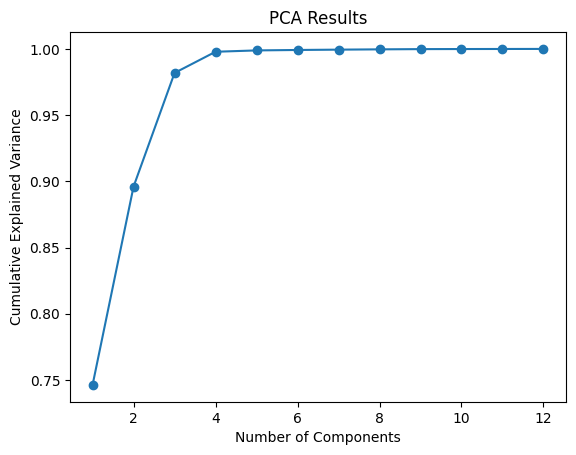

In [113]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=12)
principal_components =  pca.fit_transform(cleaned_data)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance: ", explained_variance)
cumulative_explained_variance = np.cumsum(explained_variance)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Results')
plt.show()


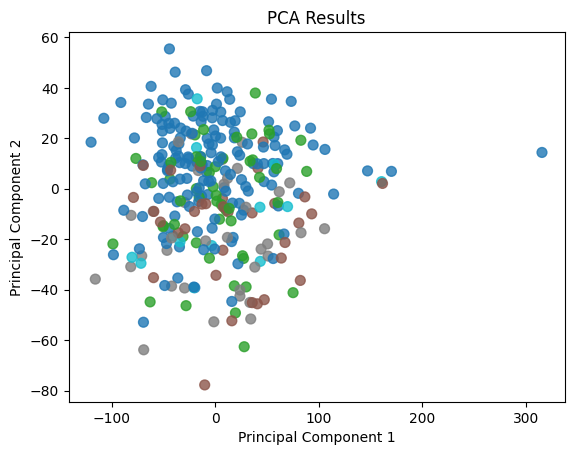

In [120]:
plt.scatter(principal_components[:, 0], principal_components[:, 1], c=labels, cmap='tab10', s=50, alpha=0.8)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Results')
plt.show()

In [121]:
from sklearn.metrics import silhouette_score
score = silhouette_score(cleaned_data, labels)
print("Silhouette: ", score)

Silhouette:  -0.03781958720068745


In [116]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

In [117]:
eps_values = np.linspace(0.1, 20.0, 50)       # try 50 values from 0.1 to 20.0
min_samples_values = range(2, 11) 

best_score = -1
best_params = None
results = []

for eps in eps_values:
    for min_s in min_samples_values:
        db = DBSCAN(eps=eps, min_samples=min_s)
        db_labels = db.fit_predict(cleaned_data)
        # need at least 2 clusters (ignoring noise) to compute silhouette
        n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
        if n_clusters < 2:
            continue

        score = silhouette_score(cleaned_data, db_labels)
        results.append((eps, min_s, score))
        if score > best_score:
            best_score = score
            best_params = (eps, min_s)

print(f"Best silhouette={best_score:.3f} with eps={best_params[0]:.3f}, min_samples={best_params[1]}")

Best silhouette=0.098 with eps=19.594, min_samples=6


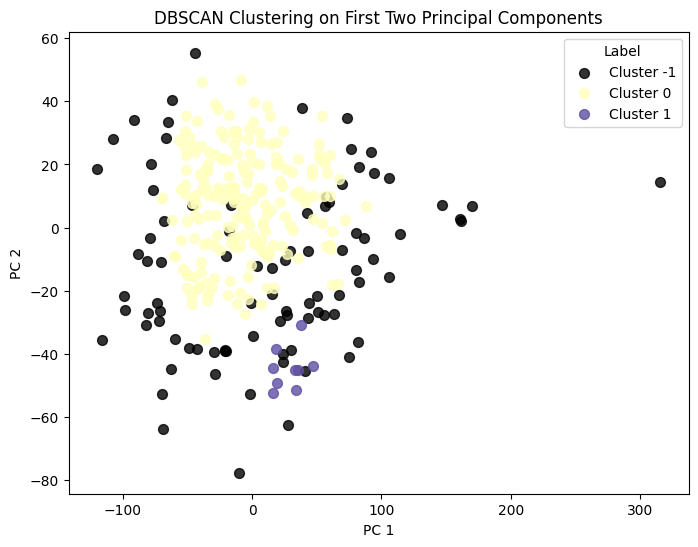

In [118]:


db_labels = DBSCAN(eps=best_params[0], min_samples=best_params[1]).fit_predict(cleaned_data)
# — or, to cluster in PC-space:
# labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(principal_components[:, :2])

# 3) Extract the first two PCs
pc1 = principal_components[:, 0]
pc2 = principal_components[:, 1]

# 4) Plot
plt.figure(figsize=(8, 6))
unique_labels = np.unique(db_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for lab, col in zip(unique_labels, colors):
    mask = (db_labels == lab)
    if lab == -1:
        # noise
        col = 'k'
    plt.scatter(
        pc1[mask],
        pc2[mask],
        c=[col],
        label=f'Cluster {lab}',
        s=50,
        alpha=0.8
    )

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('DBSCAN Clustering on First Two Principal Components')
plt.legend(title='Label')
plt.show()

KMEANS

In [119]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score

# Suppose cleaned_data has shape (n_samples, n_features)
# and you’ve already done:
# labels = cleaned_data[:, -1]
# cleaned_data = cleaned_data[:, :-1]

X = cleaned_data               # features
y = labels.astype(int) # true integer labels

print(labels)

# 1) Fit K-Means with as many clusters as unique labels
n_clusters = len(np.unique(y))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_ids = kmeans.fit_predict(X)

# 2) Build mapping from each cluster → most common true label in that cluster
mapping = {}
for cluster in np.unique(cluster_ids):
    mask = (cluster_ids == cluster)
    true_labels_in_cluster = y[mask]
    # find the label that appears most often
    most_common = np.bincount(true_labels_in_cluster).argmax()
    mapping[cluster] = most_common

# 3) Apply mapping to get “predicted” labels
y_pred = np.array([mapping[c] for c in cluster_ids])

# 4) Compute accuracy
acc = accuracy_score(y, y_pred)
print(f"K-Means clustering accuracy: {acc:.2%}")


[0. 2. 1. 0. 0. 0. 3. 0. 2. 1. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 3.
 4. 0. 0. 0. 0. 3. 0. 2. 1. 0. 0. 0. 3. 1. 3. 0. 4. 0. 0. 0. 1. 4. 0. 4.
 0. 0. 0. 0. 2. 0. 1. 1. 1. 1. 0. 0. 2. 0. 1. 0. 2. 2. 1. 0. 2. 1. 0. 3.
 1. 1. 1. 0. 1. 0. 0. 3. 0. 0. 0. 3. 0. 0. 0. 0. 0. 0. 3. 0. 0. 0. 1. 2.
 3. 0. 0. 0. 0. 0. 0. 3. 0. 2. 1. 2. 3. 1. 1. 0. 2. 2. 0. 0. 0. 3. 2. 3.
 4. 0. 3. 1. 0. 3. 3. 0. 0. 0. 0. 0. 0. 0. 0. 4. 3. 1. 0. 0. 1. 0. 1. 0.
 1. 4. 0. 0. 0. 0. 0. 0. 4. 3. 1. 1. 1. 2. 0. 0. 4. 0. 0. 0. 0. 0. 1. 0.
 3. 0. 1. 0. 4. 1. 0. 1. 0. 0. 3. 2. 0. 0. 1. 0. 0. 2. 1. 2. 0. 3. 2. 0.
 3. 0. 0. 0. 1. 0. 0. 0. 0. 0. 3. 3. 3. 0. 1. 0. 4. 0. 3. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 3. 1. 0. 0. 0. 3. 2. 0. 2. 1. 0. 0. 3. 2. 1. 0. 0. 0. 0. 0.
 2. 0. 2. 2. 1. 3. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 3. 0. 0. 4. 2. 2.
 1. 0. 1. 0. 2. 0. 1. 0. 0. 0. 1. 0. 2. 0. 3. 0. 2. 4. 2. 0. 0. 1. 0. 2.
 2. 1. 0. 3. 1. 1. 2. 3. 1.]
K-Means clustering accuracy: 54.55%


Naive Bayes

In [ ]:
import numpy as np
from sklearn.naive_bayes import GaussianNB, CategoricalNB

# Sample data: mixed continuous and categorical features
X_continuous_cols = [1, 2, 5, 8, 10, 12]
X_continuous_data = cleaned_data[:, X_continuous_cols]
X_categorical_cols = [0, 3, 4, 6, 7, 9, 11]
X_categorical_data = cleaned_data[:, X_categorical_cols]


# Separate features for each Naive Bayes model
X = np.concatenate((X_continuous_data, X_categorical_data), axis=1)

# Train GaussianNB for continuous features
gaussian_model = GaussianNB()
gaussian_model.fit(X_continuous_data, y)

# Train CategoricalNB for categorical features
categorical_model = CategoricalNB()
categorical_model.fit(X_categorical_data, y)

# Combine predictions
def predict_mixed_nb(X_continuous, X_categorical):
    gaussian_probs = gaussian_model.predict_proba(X_continuous)
    categorical_probs = categorical_model.predict_proba(X_categorical)
    
    combined_probs = []
    for i in range(len(gaussian_probs)):
        combined_prob = gaussian_probs[i] * categorical_probs[i]
        combined_probs.append(combined_prob / np.sum(combined_prob))
    return np.argmax(combined_probs, axis=1)

# Example prediction
for i in range(X_continuous_data):
    prediction[] = predict_mixed_nb
X_continuous_test = np.array([[2.0, 2.5]])
X_categorical_test = np.array([['B', 'A']])
prediction = predict_mixed_nb(X_continuous_test, X_categorical_test)
print(f"Prediction: {prediction}")

XG boost

In [123]:
from xgboost import XGBClassifier

X = cleaned_data            # features, shape (n_samples, n_features)
y = labels.astype(int)      # true labels

# 1) instantiate the model
model = XGBClassifier(
    use_label_encoder=False,   # suppress XGBoost warning
    eval_metric='logloss',     # for binary/multiclass
    random_state=42
)

# 2) fit on the full dataset
model.fit(X[:-30], y[:-30])

# 3) predict on the same data
y_pred = model.predict(X[-30:])

# 4) compute accuracy
acc = accuracy_score(y[-30:], y_pred)
print(f"XGBoost accuracy on training set: {acc:.2%}")

C:\ComputerScience\DataMining\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:25:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost accuracy on training set: 46.67%
